### A Start at some correspondence analysis like I did for Corpus Linguistics

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')

[Skip to load previously saved contingency table](#loadctab)

In [2]:
# Load the two data sets needed
# string encodings to try utf_8, iso8859_15
facetPlotData = pd.read_csv('facetPlotData.csv')
df = pd.read_csv('fullEmotionData.csv', encoding='utf-8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

(3000, 4)

<A HREF="https://regexr.com/">RegExr</A>

In [5]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [6]:
punc = '''!()-[]{};:"\,<>./?—â@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source][i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

In [7]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 'â', '\x99s', '\x99t', '\x99ve', '\x99m','\x99re']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words = text.ENGLISH_STOP_WORDS.union(stop_list)

for source in sources:
    for i in range(len(df[source])):
        df.loc[i, source] = ' '.join([word for word in df[source][i].split() if word.lower() not in stop_words])

In [8]:
# Create a frequency list of all words in all Obama speeches

# How to flatten a list
#[item for sublist in list_of_lists for item in sublist]

freqlist = nltk.FreqDist([word.lower() for text in df['text_oba'] for word in text.split()])
freqlist

FreqDist({'people': 1092, 'america': 738, 'new': 684, 'world': 644, 'american': 558, 'know': 557, 'time': 536, 'work': 535, 'years': 497, 'country': 473, ...})

In [9]:
sorted(dict(freqlist).items(),key=lambda x:x[1], reverse=True)[:20]

[('people', 1092),
 ('america', 738),
 ('new', 684),
 ('world', 644),
 ('american', 558),
 ('know', 557),
 ('time', 536),
 ('work', 535),
 ('years', 497),
 ('country', 473),
 ('want', 472),
 ('states', 469),
 ('americans', 461),
 ('like', 457),
 ('united', 456),
 ('going', 443),
 ('today', 440),
 ('jobs', 395),
 ('right', 394),
 ('need', 364)]

In [10]:
# list of all the words in the freqlist which is from all 100 documents
words = list(set(dict(freqlist).keys()))
# was getting a weird error below, just making sure all are strings, no numbers
words = [str(word) for word in words] 

### Create Contingency Table - counts of all words in all the documents

In [11]:
# Get counts of all words in 'words' for each speech/article
# I'm doing this the slow way so I can be sure the results are correct.
# I was getting weird numbers using other methods, 
#    like using sklearn countvectorizer I was getting 2900 for 'deepwater' when it should be 4
# I realize this is ugly and slow
counts = []
for i in range(len(df['text_oba'])):
    sums = []
    for word in words:
        summ = 0
        for docword in df['text_oba'][i].split():
            if docword == word:
                summ+=1
        sums.append(summ)
    counts.append(sums)

In [97]:
# Oh man, this is so ugly, just brute force, no style or class. Oh well, it works!
totalcounts = []
for i in range(len(words)):
    summ = 0
    for j in range(len(counts)):
        summ += counts[j][i]
    totalcounts.append(summ)      

In [99]:
# total count of 'deepwater' should be 4 from one speech
word = 'deepwater'
[vectr[words.index(word)] for vectr in counts if vectr[words.index(word)]>0]
# Now with stopwords removed its only 2, wtf????

[2]

In [100]:
# Contingency table
filenames = [name.replace('.txt', '') for name in df['file']]
conttab = pd.DataFrame(counts, columns = words, index = filenames, dtype='int')

In [101]:
conttab.loc['sum',:] = conttab.sum(axis=0)

In [102]:
conttab

,treasure,swept,1,21,redress,population,touch,21st,swipe,struck,...,old,grandparents,who'll,citizen,strategies,revolutionary,gaffes,sensible,selecting,arsenic
2008-06-04-ObamaNomination,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-05-ObamaElected,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-20-Inauguration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-04-02-G20Speech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-17-BatonRougeFloods,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-09-05-G20Summit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11-FarewellAddress,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# And here is the full Contingency Table, sorted with most frequent words first
conttab.sort_values(by='sum', axis=1, ascending=False, inplace=True)
conttab.drop('sum', inplace=True)
conttab

,people,new,world,know,work,time,years,want,country,like,...,hennessy,afghan,aleman,yahoo,november,eduardo,microsystems,sor,machel,roseburg
2008-06-04-ObamaNomination,20.0,18.0,6.0,8.0,10.0,30.0,12.0,12.0,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-05-ObamaElected,12.0,10.0,5.0,7.0,3.0,7.0,4.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,6.0,1.0,0.0,2.0,4.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-20-Inauguration,6.0,11.0,6.0,4.0,6.0,5.0,1.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-04-02-G20Speech,4.0,2.0,6.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-28-DemocraticConvention,21.0,10.0,8.0,18.0,13.0,7.0,18.0,7.0,13.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-17-BatonRougeFloods,13.0,1.0,0.0,9.0,3.0,1.0,0.0,14.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-05-G20Summit,3.0,3.0,2.0,0.0,1.0,1.0,6.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,7.0,0.0,3.0,5.0,9.0,3.0,4.0,3.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save contingency table, change destination file name

In [104]:
# Save table so we don't have to do this again
#conttab.to_csv('obamaContingencyTable_noSW.csv')

<a id='loadctab'>Load Contingency Table</a>

In [106]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])

In [107]:
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

In [108]:
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='auto',
               random_state=33)

In [109]:
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort)

In [110]:
ca.row_coordinates(ctabshort).head()

,0,1
2008-06-04,-0.065735,0.154012
2008-11-05,0.105637,-0.078222
2009-01-05,-0.443948,-0.320922
2009-01-20,0.305034,0.132078
2009-04-02,0.200668,-0.124966


In [111]:
ca.column_coordinates(ctabshort).head()

,0,1
people,0.239138,0.064366
new,-0.105504,-0.108166
world,0.544811,-0.021456
know,-0.083612,-0.111452
work,-0.061765,-0.051342


/home/muddy/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 153 (\x99) missing from current font.
  func(*args, **kwargs)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 157 (\x9d) missing from current font.
  func(*args, **kwargs)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 147 (\x93) missing from current font.
  func(*args, **kwargs)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, *

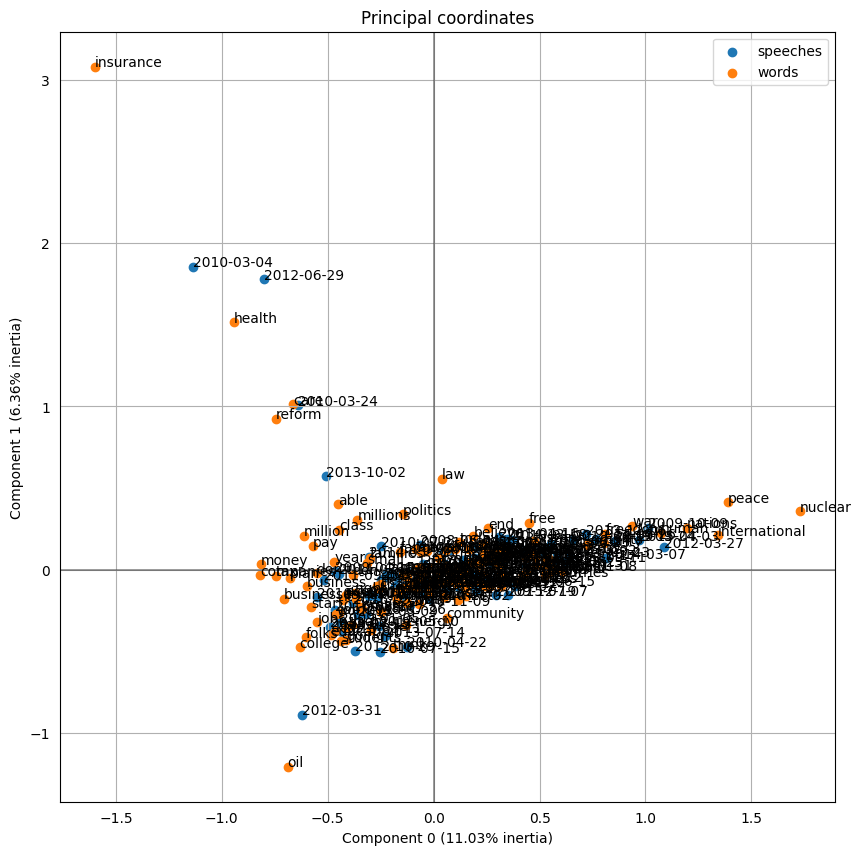

In [112]:
ax = ca.plot_coordinates(X=ctabshort,
                         ax=None,
                         figsize=(10, 10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)

<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


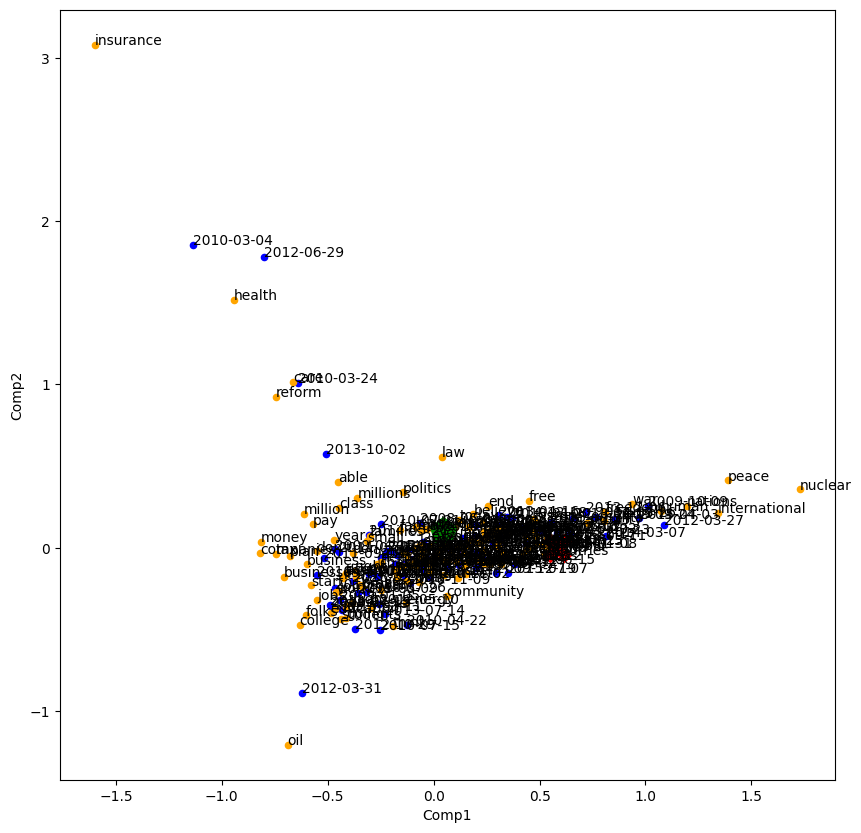

In [114]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

#plt.xlim([-0.3, 0.1])
#plt.ylim([-0.6, 0.0])
plt.show()

### Try correspondence analysis on a pre-selected list of words

In [115]:
# Load words from file
# topic words from topic modeling: "./word_lists/topic-words.txt"
# a custom list: "./word_lists/customlist.txt"
# common adjective: "./word_lists/adjectives.txt"
# common adverbs: "./word_lists/adverbs.txt"
# function words: "./word_lists/function-words.txt"
wordList = pd.read_csv("./word_lists/adjectives.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [116]:
# Make a short contingency list using topic words
ctabshort2 = ctab.loc[ : , [col for col in ctab.columns if col in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort2)[1] > 150:
    ctabshort2=ctabshort2.iloc[:, : 150]
    
ctabshort2.columns.rename('words', inplace=True)
ctabshort2.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort2)

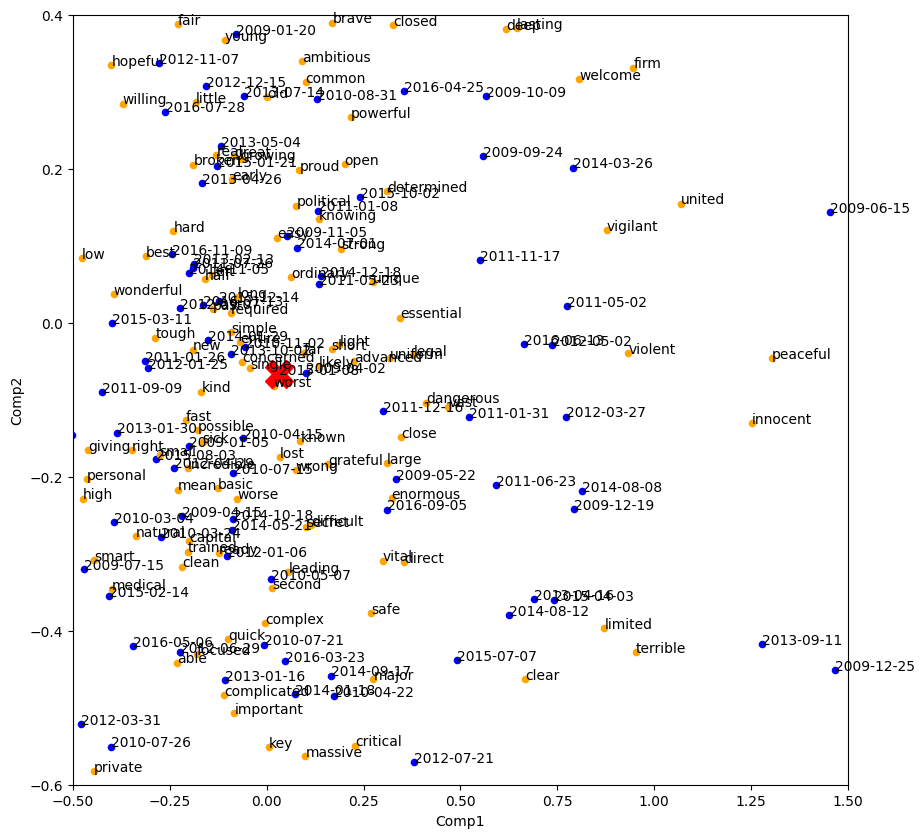

In [117]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort2)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort2)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.5, 1.5])
plt.ylim([-0.6, 0.4])
plt.show()

### Now try using the most frequent 150 words after removing the Kaggle 700 stop words

In [118]:
# Load words from file
# Kaggle stop words: "./word_lists/kaggle_stopwords.txt"
wordList = pd.read_csv("./word_lists/kaggle_stopwords.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [119]:
number_of_words = 400
# Make a short contingency list removing the Kaggle stop words
ctabshort3 = ctab.loc[ : , [col for col in ctab.columns if col not in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort3)[1] > number_of_words:
    ctabshort3=ctabshort3.iloc[:, : number_of_words]
    
ctabshort3.columns.rename('words', inplace=True)
ctabshort3.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort3)

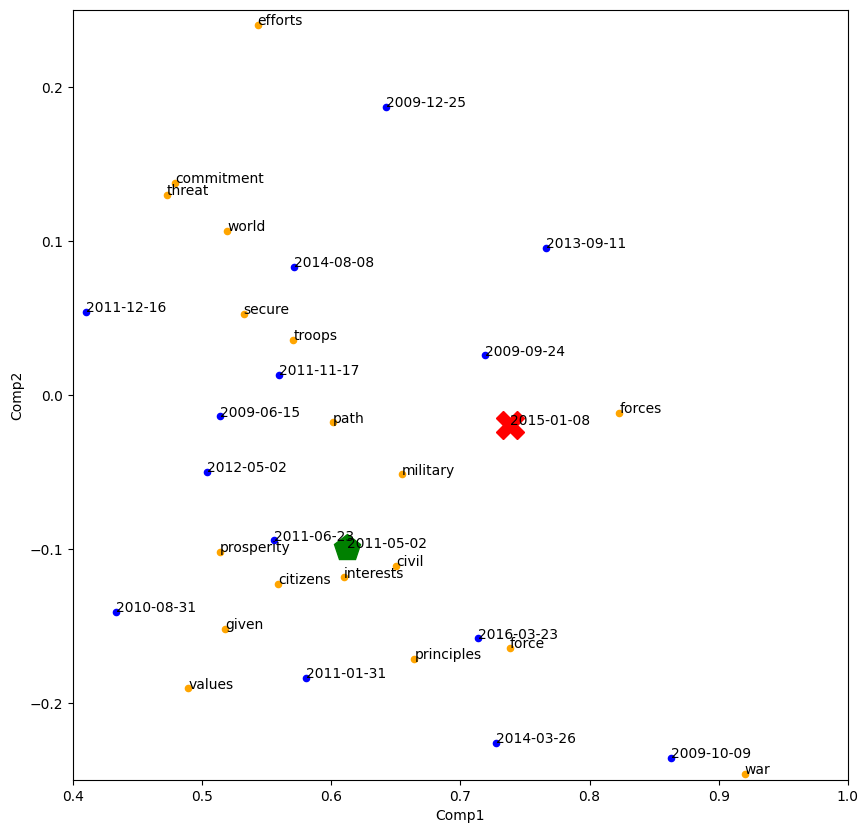

In [122]:
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([0.4, 1.0])
plt.ylim([-0.25, 0.25])
plt.show()